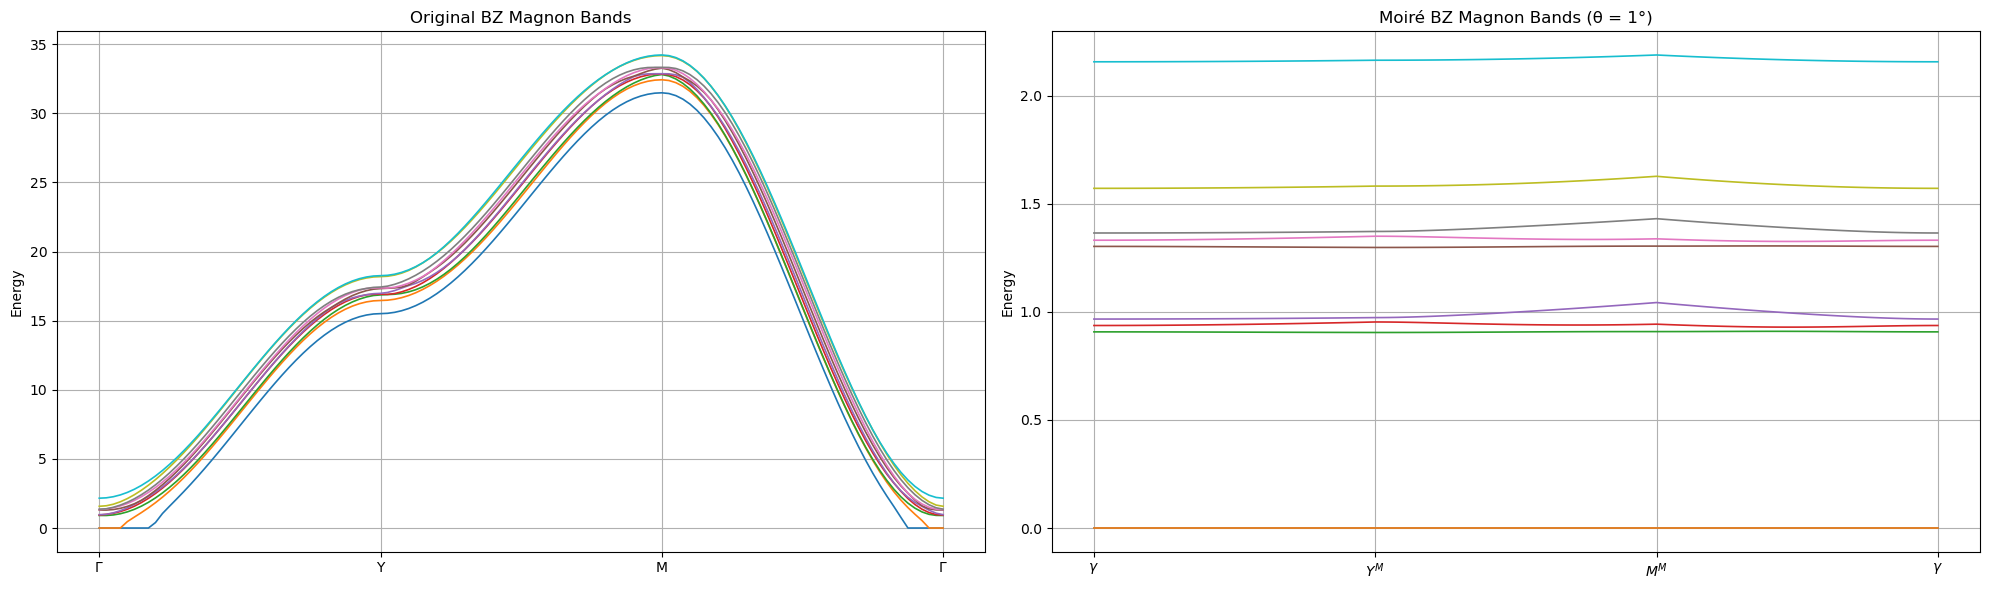

Threshold field B_c = 1.045


In [48]:
import numpy as np
import matplotlib.pyplot as plt


# Parámetros físicos
S = 3/2
a = 3.54
b = 4.73
z = 4  # número de coordinación
J = 4/S
JT = 0.395/S
Da = 0.383/S
Dc = 1.30/S
B = 0.8
theta_deg = 1
theta = np.radians(theta_deg)
# SPATIALLY-MODULATED J_T(R)
J_0 = JT
J_G = JT
# TYPE OF MBZ MAGNON
k_0=np.array([0, 0]) #TYPE OF MAGNON: 0 -> \Gamma, (PI/A, 0) -> Y, S -> (PI/A, PI/B)


#OUR MODEL: NN IN MOIRE RECIPROCAL SPACE -- FIRST ORDER IN MOIRE PLANE-WAVE EXPANSION
# Vectores recíprocos moiré
G_list = [np.array([0, 0]),
          np.array([4*np.pi*np.sin(theta/2)/b, 0]),
          -np.array([4*np.pi*np.sin(theta/2)/b, 0]),
          np.array([0, -4*np.pi*np.sin(theta/2)/a]),
          -np.array([0, -4*np.pi*np.sin(theta/2)/a])]


# SPATIALLY-MODULATED CANTING ANGLE \CHI(R)
threshold = (Da*np.cos(theta)*(2*S-1)/2 + 2*S*J_0)
if B < threshold:
    sin_chi_0 = B / threshold
    chi_0 = np.arcsin(sin_chi_0)
    cos_chi_0 = np.sqrt(1 - sin_chi_0**2)
    chi_G=-2*S*B*J_G/(cos_chi_0*threshold*threshold)
else:
    chi_0 = np.pi / 2
    sin_chi_0 = 1.0
    cos_chi_0 = 0.0
    chi_G=0

cos_2chi_0 = np.cos(2 * chi_0)
sin_2chi_0 = np.sin(2 * chi_0)

N_G = len(G_list)
dim = 4 * N_G

def gamma_k(k):
    return 2 * (np.cos(a * k[0]) + np.cos(b * k[1]))

# Coeficientes onsite
def h_d(k):
    return J_0*S*np.cos(2*chi_0) - J*S*(gamma_k(k) - z) + \
           Da*(S*np.cos(chi_0 + theta/2)**2 - (2*S - 1)*np.sin(chi_0 + theta/2)**2)/2 + \
           Dc*S/2 + B*np.sin(chi_0)

h_aa = -Da*S*np.cos(chi_0 + theta/2)**2/4 + Dc*S/4

# Coeficientes de acoplo directo entre capas
h_ab = J_0 * S * (1 + np.cos(2*chi_0)) / 2
h_abdag = J_0 * S * (1 - np.cos(2*chi_0)) / 2

# Construcción de H(k)
def build_H(k):
    H = np.zeros((dim, dim), dtype=np.complex128)
    for i, Gi in enumerate(G_list):
        ki = k +  - Gi
        idx_i = 4 * i

        # Términos diagonales
        H[idx_i, idx_i] = h_d(ki)
        H[idx_i+1, idx_i] = h_aa
        H[idx_i+1, idx_i+1] = h_d(ki)
        H[idx_i, idx_i+1] = h_aa

        H[idx_i+2, idx_i+2] = h_d(ki)
        H[idx_i+3, idx_i+2] = h_aa
        H[idx_i+3, idx_i+3] = h_d(ki)
        H[idx_i+2, idx_i+3] = h_aa

        # Acoplos directos
        H[idx_i, idx_i+2] = h_abdag
        H[idx_i, idx_i+3] = h_ab
        H[idx_i+1, idx_i+2] = h_ab
        H[idx_i+1, idx_i+3] = h_abdag

        H[idx_i+2, idx_i] = h_abdag
        H[idx_i+3, idx_i] = h_ab
        H[idx_i+2, idx_i+1] = h_ab
        H[idx_i+3, idx_i+1] = h_abdag

    # Interacción moiré entre G≠0
    for i in range(1, N_G):
        idx_i = 4 * i

        hM_d = J_G*S*np.cos(2*chi_0) + chi_G*(-2*S*J_0*np.sin(2*chi_0) - Da*(3*S-1)*np.sin(2*chi_0 + theta)/2 + B*np.cos(chi_0))
        hM_aa = Da*S*np.sin(2*chi_0 + theta)*chi_0 / 4
        hM_ab = J_G*S*(1 + np.cos(2*chi_0))/2 - S*J_0*np.sin(2*chi_0)*chi_G
        hM_abdag = J_G*S*(1 - np.cos(2*chi_0))/2 + S*J_0*np.sin(2*chi_0)*chi_G

        # Diagonal
        H[idx_i, 0] = hM_d
        H[idx_i+1, 0] = hM_aa
        H[idx_i+1, 1] = hM_d
        H[idx_i, 1] = hM_aa

        H[idx_i+2, 2] = hM_d
        H[idx_i+3, 2] = hM_aa
        H[idx_i+3, 3] = hM_d
        H[idx_i+2, 3] = hM_aa

        H[0, idx_i] = hM_d
        H[0, idx_i+1] = hM_aa
        H[1, idx_i+1] = hM_d
        H[1, idx_i] = hM_aa

        H[2, idx_i+2] = hM_d
        H[2, idx_i+3] = hM_aa
        H[3, idx_i+3] = hM_d
        H[3, idx_i+2] = hM_aa

        # Intercapa moiré
        H[idx_i, 2] = hM_abdag
        H[idx_i, 3] = hM_ab
        H[idx_i+1, 2] = hM_ab
        H[idx_i+1, 3] = hM_abdag

        H[idx_i+2, 0] = hM_abdag
        H[idx_i+3, 0] = hM_ab
        H[idx_i+2, 1] = hM_ab
        H[idx_i+3, 1] = hM_abdag

        H[2, idx_i] = hM_abdag
        H[3, idx_i] = hM_ab
        H[2, idx_i+1] = hM_ab
        H[3, idx_i+1] = hM_abdag

        H[0, idx_i+2] = hM_abdag
        H[0, idx_i+3] = hM_ab
        H[1, idx_i+2] = hM_ab
        H[1, idx_i+3] = hM_abdag

    return H

# Matriz BdG
S_bdg = np.diag([1 if i % 2 == 0 else -1 for i in range(dim)])

# Generate both BZ and MBZ paths
# Original BZ path (theta=0)
ky_max_bz = np.pi / a
kz_max_bz = np.pi / b
Gamma_bz = np.array([0, 0])
Y_bz = np.array([ky_max_bz, 0])
M_bz = np.array([ky_max_bz, kz_max_bz])
path_bz = [Gamma_bz, Y_bz, M_bz, Gamma_bz]

# Moiré BZ path (theta != 0)
ky_max_mbz = 2 * np.pi * np.sin(theta/2) / b
kz_max_mbz = 2 * np.pi * np.sin(theta/2) / a
Gamma_mbz = np.array([0, 0])
Y_mbz = np.array([ky_max_mbz, 0])
M_mbz = np.array([ky_max_mbz, kz_max_mbz])
path_mbz = [Gamma_mbz, Y_mbz, M_mbz, Gamma_mbz]

def interpolate_path(path, n_points=50):
    k_points = []
    for i in range(len(path)-1):
        start, end = path[i], path[i+1]
        for t in np.linspace(0, 1, n_points, endpoint=False):
            k_points.append((1-t)*start + t*end)
    k_points.append(path[-1])
    return np.array(k_points)

# Calculate eigenvalues for both paths
k_path_bz = interpolate_path(path_bz, n_points=40)
k_path_mbz = interpolate_path(path_mbz, n_points=40)

eigvals_bz = []
eigvals_mbz = []

for k in k_path_bz:
    Hk = build_H(k)
    Hk_bdg = S_bdg @ Hk
    w_bz, _ = np.linalg.eig(Hk_bdg)
    eigvals_bz.append(np.sort(np.real(w_bz))[-2 * N_G:])

k_shift=np.array([np.cos(theta/2)*k_0[0]-np.sin(theta/2)*k_0[1], np.sin(theta/2)*k_0[0]+np.cos(theta/2)*k_0[1]])
for k in k_path_mbz:
    Hk = build_H(k+ k_shift)
    Hk_bdg = S_bdg @ Hk
    w_mbz, _ = np.linalg.eig(Hk_bdg)
    eigvals_mbz.append(np.sort(np.real(w_mbz))[-2 * N_G:])

eigvals_bz = np.array(eigvals_bz)
eigvals_mbz = np.array(eigvals_mbz)

# Plot both figures side by side
plt.figure(figsize=(20, 6))

# BZ plot
plt.subplot(1, 2, 1)
for band in range(2*N_G):
    plt.plot(eigvals_bz[:, band], lw=1.2)
plt.xticks([0, 40, 80, 120], [r'$\Gamma$', 'Y', 'M', r'$\Gamma$'])
plt.ylabel('Energy')
plt.title('Original BZ Magnon Bands')
plt.grid(True)

# MBZ plot
plt.subplot(1, 2, 2)
for band in range(2*N_G):
    plt.plot(eigvals_mbz[:, band], lw=1.2)
plt.xticks([0, 40, 80, 120], [r'$\gamma$', r'$Y^M$', r'$M^M$', r'$\gamma$'])
plt.ylabel('Energy')
plt.title('Moiré BZ Magnon Bands (θ = {}°)'.format(theta_deg))
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Threshold field B_c = {threshold:.3f}")

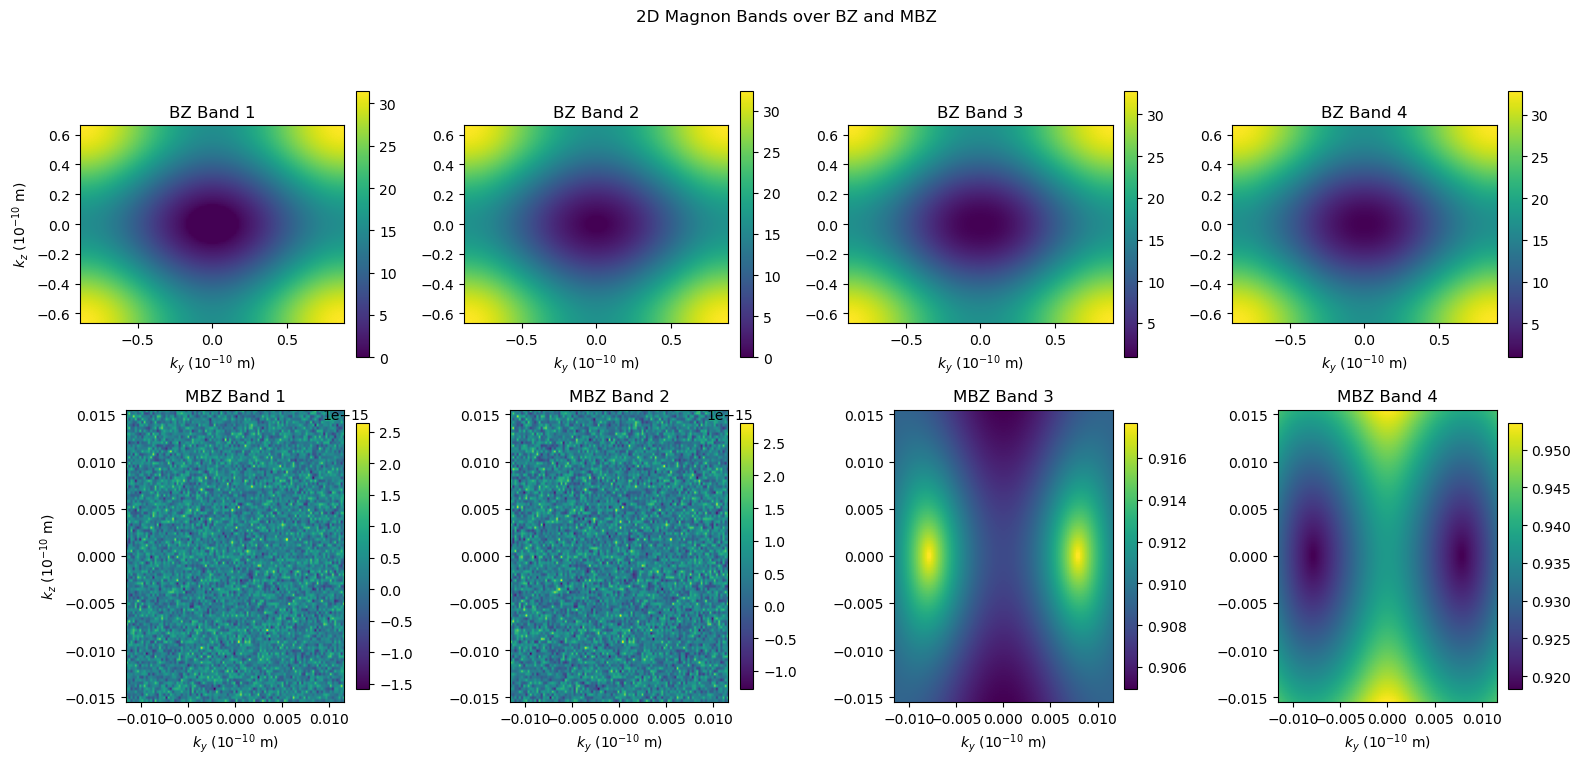

In [49]:
# --- 2D MAGNON BANDS OVER THE BZ AND MBZ ---

Nk = 100  # resolution
nbands_to_plot = 4

eigvals_bz = []
eigvals_mbz = []

# === ORIGINAL BZ ===
ky_vals_bz = np.linspace(-ky_max_bz, ky_max_bz, Nk)
kz_vals_bz = np.linspace(-kz_max_bz, kz_max_bz, Nk)
KY_bz, KZ_bz = np.meshgrid(ky_vals_bz, kz_vals_bz, indexing='ij')

bands_bz = np.zeros((Nk, Nk, nbands_to_plot))
for i in range(Nk):
    for j in range(Nk):
        k = np.array([KY_bz[i, j], KZ_bz[i, j]])
        Hk = build_H(k)
        Hk_bdg = S_bdg @ Hk
        w_bz, _ = np.linalg.eig(Hk_bdg)
        bands_bz[i, j, :] = np.sort(np.real(w_bz))[-2 * N_G:][:nbands_to_plot]

# === MOIRÉ BZ ===
ky_vals_mbz = np.linspace(-ky_max_mbz, ky_max_mbz, Nk)
kz_vals_mbz = np.linspace(-kz_max_mbz, kz_max_mbz, Nk)
KY_mbz, KZ_mbz = np.meshgrid(ky_vals_mbz, kz_vals_mbz, indexing='ij')

bands_mbz = np.zeros((Nk, Nk, nbands_to_plot))
for i in range(Nk):
    for j in range(Nk):
        k = np.array([KY_mbz[i, j], KZ_mbz[i, j]])
        Hk = build_H(k+ k_shift)
        Hk_bdg = S_bdg @ Hk
        w_mbz, _ = np.linalg.eig(Hk_bdg)
        bands_mbz[i, j, :] = np.sort(np.real(w_mbz))[-2 * N_G:][:nbands_to_plot]

# --- PLOT BZ AND MBZ 2D COLOR MAPS ---
fig, axs = plt.subplots(2, nbands_to_plot, figsize=(4 * nbands_to_plot, 8))

for b in range(nbands_to_plot):
    # Original BZ (top row)
    im_bz = axs[0, b].imshow(bands_bz[:, :, b], origin='lower',
                             extent=[-ky_max_bz, ky_max_bz, -kz_max_bz, kz_max_bz],
                             cmap='viridis', aspect='equal')
    axs[0, b].set_title(f'BZ Band {b+1}')
    axs[0, b].set_xlabel(r'$k_y$ ($10^{-10}$ m)')
    if b == 0:
        axs[0, b].set_ylabel(r'$k_z$ ($10^{-10}$ m)')
    fig.colorbar(im_bz, ax=axs[0, b], fraction=0.046, pad=0.04)

    # Moiré BZ (bottom row)
    im_mbz = axs[1, b].imshow(bands_mbz[:, :, b], origin='lower',
                              extent=[-ky_max_mbz, ky_max_mbz, -kz_max_mbz, kz_max_mbz],
                              cmap='viridis', aspect='equal')
    axs[1, b].set_title(f'MBZ Band {b+1}')
    axs[1, b].set_xlabel(r'$k_y$ ($10^{-10}$ m)')
    if b == 0:
        axs[1, b].set_ylabel(r'$k_z$ ($10^{-10}$ m)')
    fig.colorbar(im_mbz, ax=axs[1, b], fraction=0.046, pad=0.04)

plt.suptitle('2D Magnon Bands over BZ and MBZ')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

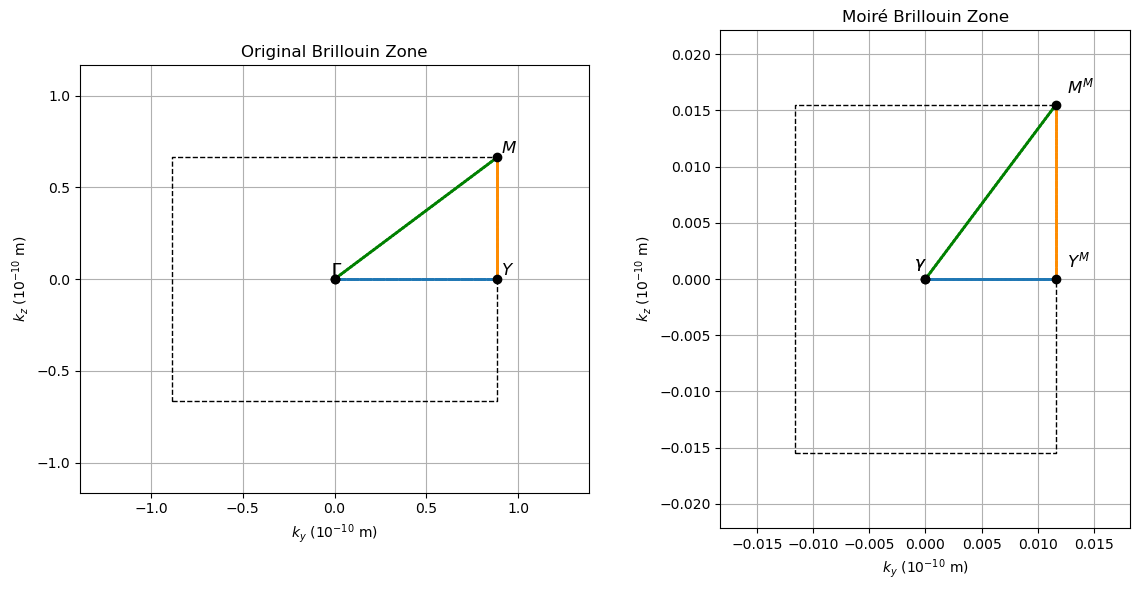

In [51]:
# Lattice constants (rectangular) - THETA IS DEFINED IN THE 1D MAGNON BANDS CELL
a = 3.54
b = 4.73

# ====================== Original BZ ======================
G_bz = np.array([0, 0])                     # Gamma
Y_bz = np.array([np.pi / a, 0])             # Y
M_bz = np.array([np.pi / a, np.pi / b])     # M

path_bz = [G_bz, Y_bz, M_bz, G_bz]
labels_bz = [r'$\Gamma$', r'$Y$', r'$M$', r'$\Gamma$']
colors_bz = ['tab:blue', 'darkorange', 'green']

# Compute k-points for original BZ
k_points_bz = []
segment_colors_bz = []
for i in range(len(path_bz) - 1):
    start, end = path_bz[i], path_bz[i+1]
    for t in np.linspace(0, 1, 50, endpoint=False):
        point = (1 - t) * start + t * end
        k_points_bz.append(point)
        segment_colors_bz.append(colors_bz[i])
k_points_bz.append(path_bz[-1])
segment_colors_bz.append(colors_bz[-1])
k_points_bz = np.array(k_points_bz)

# BZ boundaries
ky_max_bz = np.pi / a
kz_max_bz = np.pi / b
bz_vertices = np.array([
    [-ky_max_bz, -kz_max_bz],
    [ ky_max_bz, -kz_max_bz],
    [ ky_max_bz,  kz_max_bz],
    [-ky_max_bz,  kz_max_bz],
    [-ky_max_bz, -kz_max_bz]
])

# ====================== Moiré BZ ======================
G_mbz = np.array([0, 0])                     # Gamma
Y_mbz = np.array([2*np.pi*np.sin(theta/2)/b, 0])             # Y
M_mbz = np.array([2*np.pi*np.sin(theta/2)/b, 2*np.pi*np.sin(theta/2)/a])     # M

path_mbz = [G_mbz, Y_mbz, M_mbz, G_mbz]
labels_mbz = [r'$\gamma$', r'$Y^M$', r'$M^M$', r'$\gamma$']
colors_mbz = ['tab:blue', 'darkorange', 'green']

# Compute k-points for Moiré BZ
k_points_mbz = []
segment_colors_mbz = []
for i in range(len(path_mbz) - 1):
    start, end = path_mbz[i], path_mbz[i+1]
    for t in np.linspace(0, 1, 50, endpoint=False):
        point = (1 - t) * start + t * end
        k_points_mbz.append(point)
        segment_colors_mbz.append(colors_mbz[i])
k_points_mbz.append(path_mbz[-1])
segment_colors_mbz.append(colors_mbz[-1])
k_points_mbz = np.array(k_points_mbz)

# Moiré BZ boundaries
ky_max_mbz = 2*np.pi*np.sin(theta/2)/b
kz_max_mbz = 2*np.pi*np.sin(theta/2)/a
mbz_vertices = np.array([
    [-ky_max_mbz, -kz_max_mbz],
    [ ky_max_mbz, -kz_max_mbz],
    [ ky_max_mbz,  kz_max_mbz],
    [-ky_max_mbz,  kz_max_mbz],
    [-ky_max_mbz, -kz_max_mbz]
])

# ====================== Plot Both ======================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ----- Original BZ Plot -----
ax1.plot(bz_vertices[:,0], bz_vertices[:,1], 'k--', linewidth=1)
for i in range(len(k_points_bz) - 1):
    x_vals = [k_points_bz[i][0], k_points_bz[i+1][0]]
    y_vals = [k_points_bz[i][1], k_points_bz[i+1][1]]
    ax1.plot(x_vals, y_vals, color=segment_colors_bz[i], linewidth=2)

off_let_bz = kz_max_bz / 30
for i, (point, label) in enumerate(zip(path_bz, labels_bz)):
    ax1.plot(point[0], point[1], 'ko')
    if i == 0 or i == len(path_bz) - 1:
        ax1.text(point[0] - off_let_bz, point[1] + off_let_bz, label, fontsize=12)
    else:
        ax1.text(point[0] + off_let_bz, point[1] + off_let_bz, label, fontsize=12)

ax1.set_xlim(-ky_max_bz - 0.5, ky_max_bz + 0.5)
ax1.set_ylim(-kz_max_bz - 0.5, kz_max_bz + 0.5)
ax1.set_aspect('equal')
ax1.set_title('Original Brillouin Zone')
ax1.set_xlabel(r'$k_y$ ($10^{-10}$ m)')
ax1.set_ylabel(r'$k_z$ ($10^{-10}$ m)')
ax1.grid(True)

# ----- Moiré BZ Plot -----
#OFFSET DE LAS LETRAS Y EL PLOT GENERAL
off_let_mbz=kz_max_bz/650
off_grid_mbz=kz_max_bz/100

ax2.plot(mbz_vertices[:,0], mbz_vertices[:,1], 'k--', linewidth=1)
for i in range(len(k_points_mbz) - 1):
    x_vals = [k_points_mbz[i][0], k_points_mbz[i+1][0]]
    y_vals = [k_points_mbz[i][1], k_points_mbz[i+1][1]]
    ax2.plot(x_vals, y_vals, color=segment_colors_mbz[i], linewidth=2)

for i, (point, label) in enumerate(zip(path_mbz, labels_mbz)):
    ax2.plot(point[0], point[1], 'ko')
    if i == 0 or i == len(path_mbz) - 1:
        ax2.text(point[0] - off_let_mbz, point[1] + off_let_mbz, label, fontsize=12)
    else:
        ax2.text(point[0] + off_let_mbz, point[1] + off_let_mbz, label, fontsize=12)

ax2.set_xlim(-ky_max_mbz - off_grid_mbz, ky_max_mbz + off_grid_mbz)
ax2.set_ylim(-kz_max_mbz - off_grid_mbz, kz_max_mbz + off_grid_mbz)
ax2.set_aspect('equal')
ax2.set_title('Moiré Brillouin Zone')
ax2.set_xlabel(r'$k_y$ ($10^{-10}$ m)')
ax2.set_ylabel(r'$k_z$ ($10^{-10}$ m)')
ax2.grid(True)

plt.tight_layout()
plt.show()


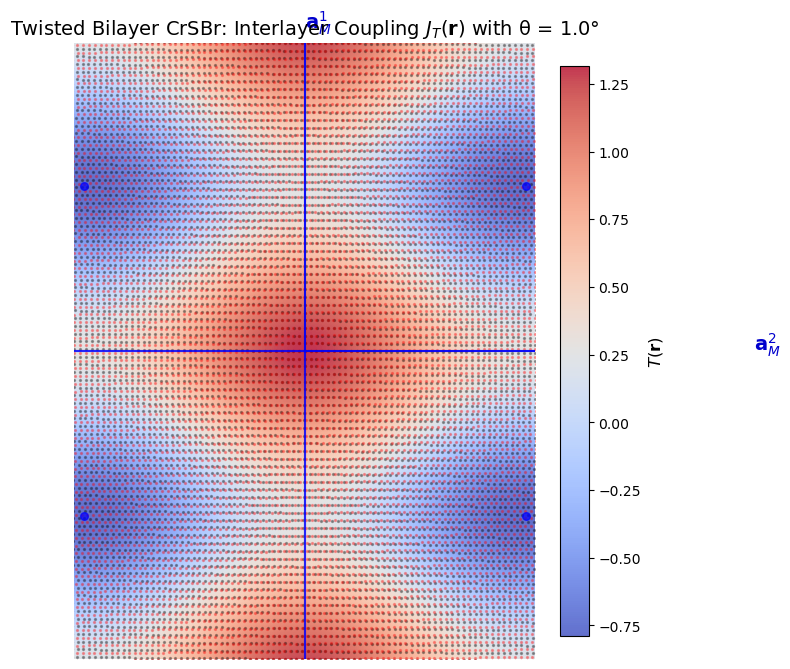

In [52]:
def generate_rect_lattice(a, b, n, theta):
    y = np.arange(-n, n+1) * a
    z = np.arange(-n, n+1) * b
    Y, Z = np.meshgrid(y, z)
    coords = np.vstack([Y.ravel(), Z.ravel()])
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    rotated_coords = R @ coords
    return rotated_coords.T

# Parameters LATTICE
n = 40

# Generate layers
bottom_layer = generate_rect_lattice(a, b, n, theta=-theta / 2)
top_layer = generate_rect_lattice(a, b, n, theta=theta / 2)

# Moiré lattice vectors
denom = 2 * np.sin(theta / 2)
aM1 = a / denom * np.array([0, 1])  # z-axis
aM2 = b / denom * np.array([1, 0])   # y-axis

# Scalar field grid
grid_res = 500
lim_y = n * a
lim_z = n * b
y = np.linspace(-lim_y, lim_y, grid_res)
z = np.linspace(-lim_z, lim_z, grid_res)
Y, Z = np.meshgrid(y, z)
ry = Y
rz = Z

# Scalar field
T = J_0+(2*J_G) * (np.cos((4 * np.pi * np.sin(theta / 2)) * rz / a) +
                 np.cos((4 * np.pi * np.sin(theta / 2)) * ry / b))

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
ax.axis('off')

# Scalar field background
im = ax.pcolormesh(y, z, T, shading='auto', cmap='coolwarm', alpha=0.8)

# Lattice layers
ax.scatter(bottom_layer[:, 0], bottom_layer[:, 1], color='black', s=2, alpha=0.3)
ax.scatter(top_layer[:, 0], top_layer[:, 1], color='red', s=2, alpha=0.3)

# Moiré lattice arrows
origin = np.array([0, 0])
ax.arrow(*origin, *aM1, color='mediumblue', width=0.03, head_width=0.3, length_includes_head=True, alpha=0.6)
ax.arrow(*origin, *aM2, color='mediumblue', width=0.03, head_width=0.3, length_includes_head=True, alpha=0.6)

# Labels
offset = 5
ax.text(*(aM1 + [0, -offset]), r'$\mathbf{a}^{1}_M$', fontsize=14, color='mediumblue', weight='bold')
ax.text(*(aM2 + [offset, 0]), r'$\mathbf{a}^{2}_M$', fontsize=14, color='mediumblue', weight='bold')

# Tiling moiré unit cells across the entire visible area
# Find max steps needed in both aM1 and aM2 directions
max_i = int(2 * lim_y / np.linalg.norm(aM2)) + 1
max_j = int(2 * lim_z / np.linalg.norm(aM1)) + 1

for i in range(-max_i, max_i + 1):
    for j in range(-max_j, max_j + 1):
        cell_origin = i * aM2 + j * aM1
        square = np.array([
            cell_origin,
            cell_origin + aM2,
            cell_origin + aM2 + aM1,
            cell_origin + aM1,
            cell_origin
        ])
        ax.plot(square[:, 0], square[:, 1], color='blue', linewidth=1.5, alpha=0.6)
        center = cell_origin + 0.5 * (aM1 + aM2)
        ax.scatter(*center, color='blue', s=30, alpha=0.7)

# Final touches
ax.set_xlim(-lim_y, lim_y)
ax.set_ylim(-lim_z, lim_z)
plt.title(f"Twisted Bilayer CrSBr: Interlayer Coupling $J_T(\mathbf{{r}})$ with θ = {theta_deg:.1f}°", fontsize=14)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"$T(\mathbf{r})$", fontsize=12)

plt.show()


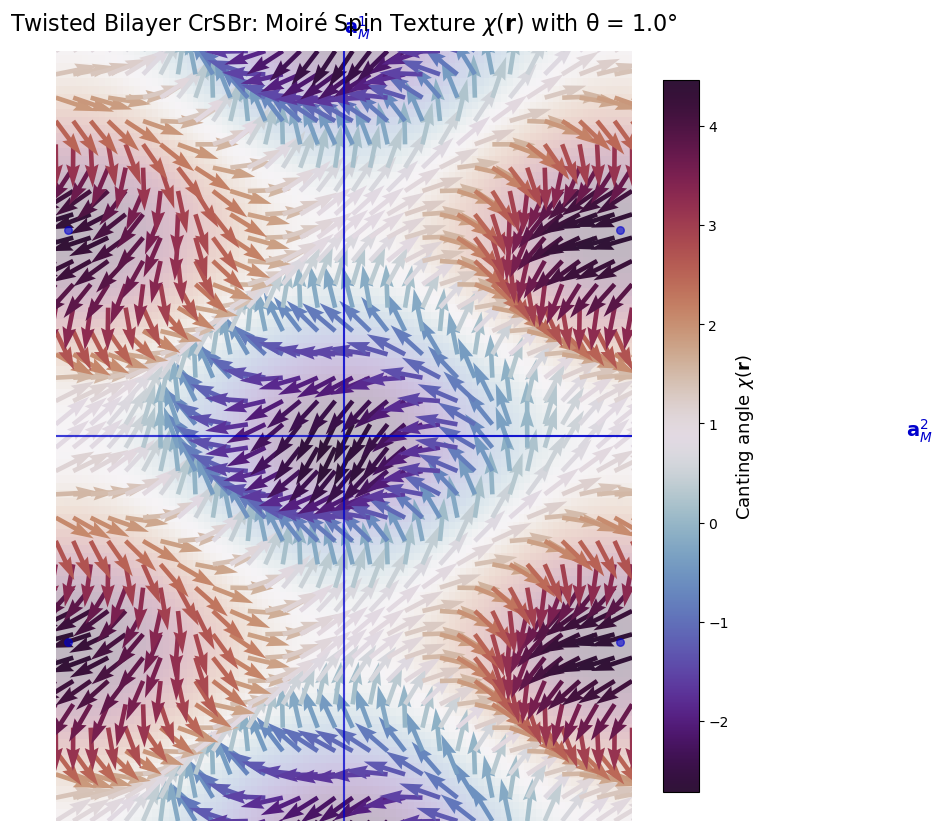

In [53]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Moiré grid
n = 40
grid_res = 100
lim_y = n * a
lim_z = n * b
y = np.linspace(-lim_y, lim_y, grid_res)
z = np.linspace(-lim_z, lim_z, grid_res)
Y, Z = np.meshgrid(y, z)
ry = Y
rz = Z

# SPATIALLY-MODULATED CANTING ANGLE \CHI(R)
JTr = (2*J_G) * (np.cos((4 * np.pi * np.sin(theta / 2)) * rz / a) +
                  np.cos((4 * np.pi * np.sin(theta / 2)) * ry / b))

# SPATIALLY-MODULATED CANTING ANGLE \CHI(R)
threshold = (Da*np.cos(theta)*(2*S-1)/2 + 2*S*J_0)
if B < threshold:
    sin_chi_0 = B / threshold
    chi_0 = np.arcsin(sin_chi_0)
    cos_chi_0 = np.sqrt(1 - sin_chi_0**2)
    chi_G=-2*S*B*J_G/(cos_chi_0*threshold*threshold)
    chi=chi_0+2*chi_G*(np.cos((4 * np.pi * np.sin(theta / 2)) * rz / a) +
                        np.cos((4 * np.pi * np.sin(theta / 2)) * ry / b))
else:
    chi = np.pi / 2 * np.ones_like(JTr)
    chi_G=0

# Spins
S_y = S * np.sin(chi)
S_z = S * np.cos(chi)

# Subsample grid for quiver — denser than before (from step=5 to step=3)
step = 3
Y_sub = Y[::step, ::step]
Z_sub = Z[::step, ::step]
S_y_sub = S_y[::step, ::step]
S_z_sub = S_z[::step, ::step]
chi_sub = chi[::step, ::step]

# Normalize colormap
norm = Normalize(vmin=np.min(chi), vmax=np.max(chi))
cmap = plt.get_cmap('twilight_shifted')  # smooth cyclic map
colors = cmap(norm(chi_sub))

# Plot
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax.set_aspect('equal')
ax.set_title(f"Twisted Bilayer CrSBr: Moiré Spin Texture $\\chi(\\mathbf{{r}})$ with θ = {theta_deg:.1f}°", fontsize=16, pad=15)

# Background scalar field for canting angle chi
im = ax.pcolormesh(y, z, chi, shading='auto', cmap='twilight_shifted', alpha=0.3)

# Quiver plot for spins
q = ax.quiver(Y_sub, Z_sub, S_y_sub, S_z_sub,
              chi_sub,  # scalar field for coloring
              cmap='twilight_shifted', norm=norm,
              scale=20, width=0.008, headlength=5)

# Moiré lattice primitive vectors
denom = 2 * np.sin(theta / 2)
aM1 = a / denom * np.array([0, 1])  # vertical vector (z direction)
aM2 = b / denom * np.array([1, 0])   # horizontal vector (y direction)

# Moiré lattice arrows with specified properties
origin = np.array([0, 0])
ax.arrow(*origin, *aM1, color='mediumblue', width=0.03, head_width=0.3,
         length_includes_head=True, alpha=0.3)
ax.arrow(*origin, *aM2, color='mediumblue', width=0.03, head_width=0.3,
         length_includes_head=True, alpha=0.6)

# Labels for lattice vectors
offset = 5
ax.text(*(aM1 + [0, -offset]), r'$\mathbf{a}^{1}_M$', fontsize=14,
        color='mediumblue', weight='bold')
ax.text(*(aM2 + [offset, 0]), r'$\mathbf{a}^{2}_M$', fontsize=14,
        color='mediumblue', weight='bold')

# Draw moiré unit cells as squares on the lattice grid
n1 = int(2 * lim_y / np.linalg.norm(aM2)) + 1
n2 = int(2 * lim_z / np.linalg.norm(aM1)) + 1

for i in range(-n1, n1 + 1):
    for j in range(-n2, n2 + 1):
        cell_origin = i * aM2 + j * aM1
        square = np.array([
            cell_origin,
            cell_origin + aM2,
            cell_origin + aM2 + aM1,
            cell_origin + aM1,
            cell_origin
        ])
        ax.plot(square[:, 0], square[:, 1], color='mediumblue', linewidth=1.5, alpha=0.5)
        center = cell_origin + 0.5 * (aM1 + aM2)
        ax.scatter(*center, color='mediumblue', s=30, alpha=0.6)

# Axis limits and styling
ax.set_xlim(-lim_y, lim_y)
ax.set_ylim(-lim_z, lim_z)
ax.axis('off')

# Colorbar for canting angle
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"Canting angle $\chi(\mathbf{r})$", fontsize=13)

plt.show()
